In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from nfmd.NFMD import NFMD

# Pull out common plotting settings:
from plot_params import get_plot_params
full_params, half_params = get_plot_params()
plt.rcParams.update(full_params)

In [2]:
def oscillator(t, y, xi, w_0, f):
    """Damped harmonic oscillator

    Keyword arguments:
    t -- time, independent variable
    y -- oscillator amplitude, dependent variable
    xi -- damping coefficient parameter
    w_0 -- resonant frequency
    f -- forcing function f(x)
    """
    y_t = y[1]
    y_tt = f(t) - (2*xi*w0)*y[1] - (w_0**2)*y[0]
    return [y_t, y_tt]


In [3]:
fs = 10e3
t_min=0
t_max = 10
n = int(t_max*fs)

# Time vector
t = np.linspace(int(t_min*fs), int(t_max*fs), n)
t /= fs

# Defined values
w0 = 50
k = 0.05
Q = 50
w_drive = 49.5

In [4]:
# Calculated values
w0 *= 2*np.pi
w_drive *= 2*np.pi
m = k/w0**2
xi = 1/(2*Q)
c = 2*xi*np.sqrt(m*k)

In [5]:
# Sort out the ICs
amp = 1e-1

delta = np.abs(np.arctan(np.divide(2 * (w_drive) * xi,
                                   (w0) ** 2 - (w_drive)** 2)))

# Set the initial conditions at t=0.
z0 = amp * np.sin(-delta)
v0 = amp * (w_drive) * np.cos(-delta)

init_vals = np.array([z0, v0])

In [6]:
# Driving force
F_0 = 0.1
f_drive = lambda x: F_0/m*np.sin(w_drive*x)

# Perturbation Force
t_p = 5
alpha = 1
tau = 0.5
f_p = lambda x: np.heaviside(x-t_p, 0)*alpha/m*(1-np.exp(-(x-t_p)/tau))

f = lambda x: f_drive(x) + f_p(x)

In [7]:
%%time

# Set the ODE function
ode_func = lambda t, y: oscillator(t, y, xi, w0, f)

# Solve it
sol = solve_ivp(ode_func,
                [t_min, t_max],
                init_vals,
                t_eval=t,
                method='RK45',
                rtol=1e-9,
                atol=1e-10)

# Set the ODE function
ode_func = lambda t, y: oscillator(t, y, xi, w0, f_p)

# Solve it
sol_p = solve_ivp(ode_func,
                  [t_min, t_max],
                  init_vals,
                  t_eval=t,
                  method='RK45',
                  rtol=1e-9,
                  atol=1e-10)

# Set the ODE function
ode_func = lambda t, y: oscillator(t, y, xi, w0, f_drive)

# Solve it
sol_drive = solve_ivp(ode_func,
                  [t_min, t_max],
                  init_vals,
                  t_eval=t,
                  method='RK45',
                  rtol=1e-9,
                  atol=1e-10)

Wall time: 22.4 s


In [8]:
# Extract the solution; trim off the transient response at beginning:
z = sol.y[0,:]
trim_sec = 4
z = z[int(fs*trim_sec):]

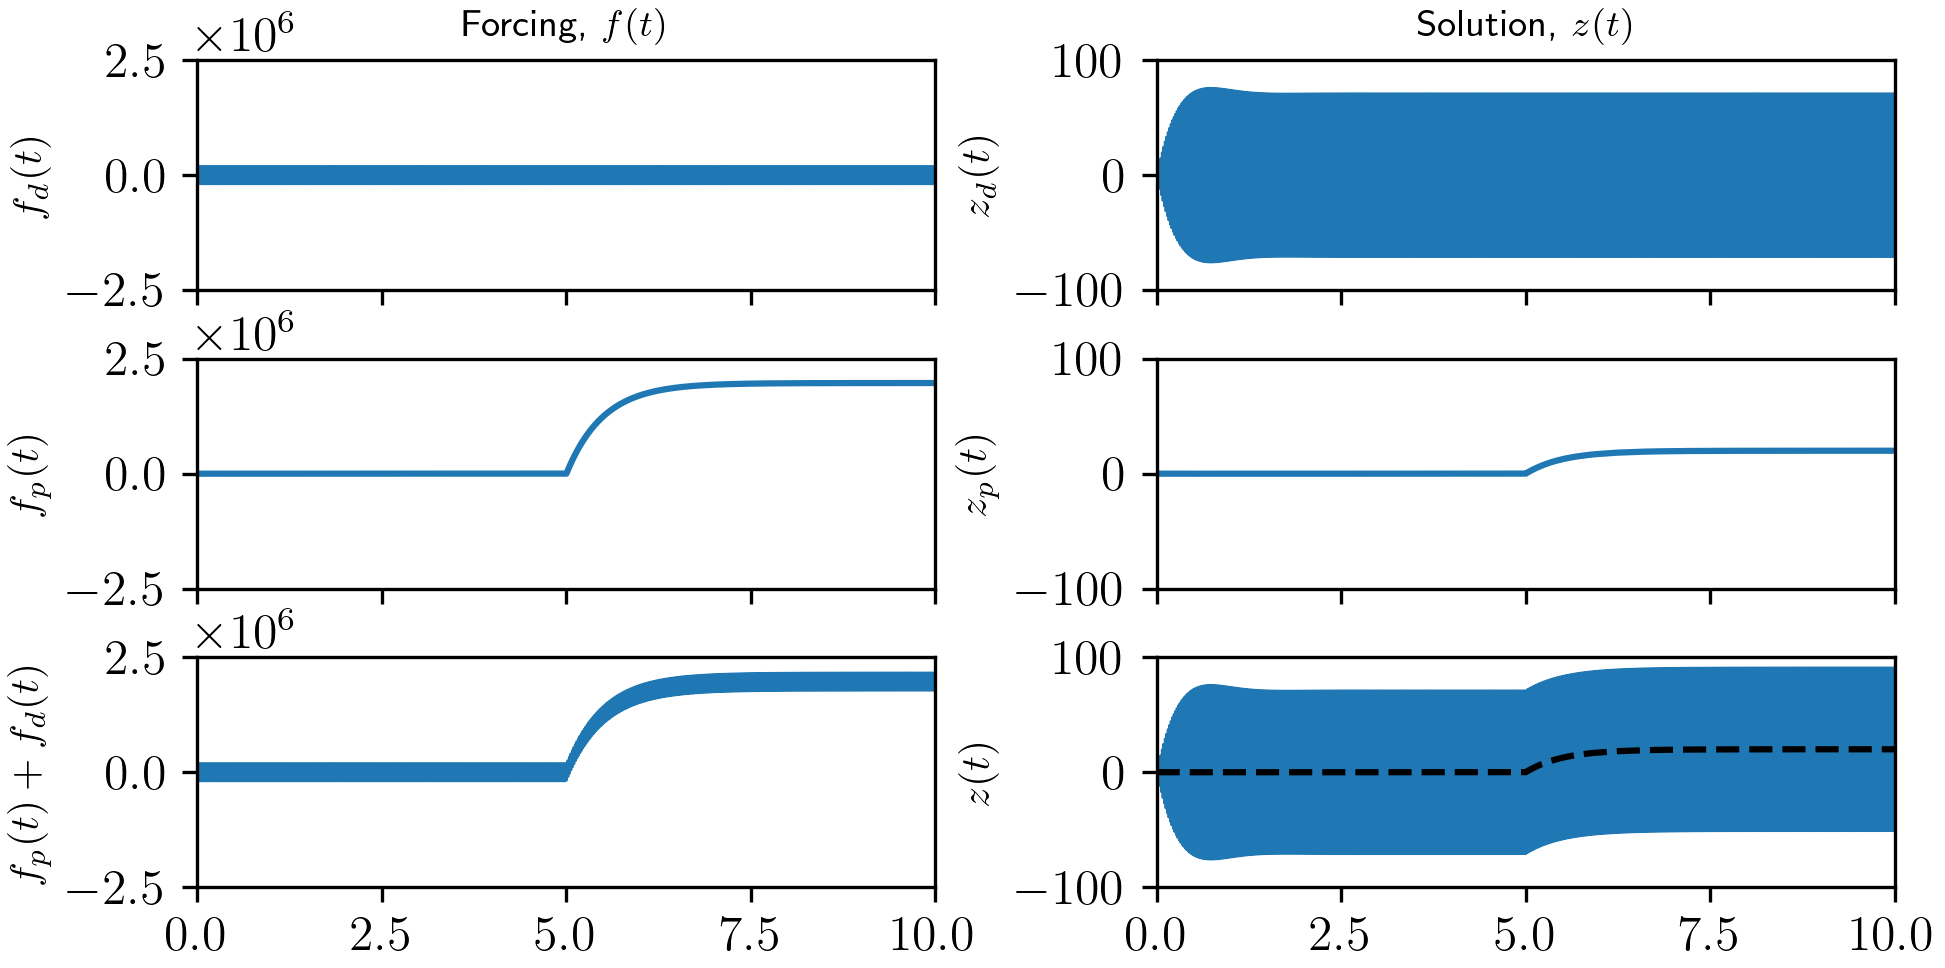

In [9]:
fig3 = plt.figure()
gs = fig3.add_gridspec(3, 2)

##############################
## Top Row -- Driving Force ##
##############################
ax1 = fig3.add_subplot(gs[0, 0])
ax1.plot(t, f_drive(t), lw=0.5)
ax1.set_ylabel("$f_d(t)$")

ax2 = fig3.add_subplot(gs[0, 1])
ax2.plot(t, sol_drive.y[0,:], lw=0.5)
ax2.set_ylabel("$z_d(t)$")

# Put titles on the 3a and 3b columns
ax1.set_title('Forcing, $f(t)$', fontsize=9)
ax2.set_title('Solution, $z(t)$', fontsize=9)

##########################################
## Second row -- Third Mode Comparisons ##
##########################################
ax3 = fig3.add_subplot(gs[1, 0], sharex=ax1)
ax3.plot(t, f_p(t))
ax3.set_ylabel("$f_p(t)$")

ax4 = fig3.add_subplot(gs[1, 1], sharex=ax2)
ax4.plot(t, sol_p.y[0,:])
ax4.set_ylabel("$z_p(t)$")

######################################
## Axes 3 -- First Mode Comparisons ##
######################################
ax5 = fig3.add_subplot(gs[2, 0], sharex=ax1)
ax5.plot(t, f(t), lw=0.5)
ax5.set_ylabel("$f_p(t)+f_d(t)$")

ax6 = fig3.add_subplot(gs[2, 1], sharex=ax2)
ax6.plot(t, sol.y[0,:], lw=0.5)
ax6.plot(t, sol_p.y[0,:], '--k')
ax6.set_ylabel("$z(t)$")

#ax7 = fig3.add_subplot(gs[2, :])

################
## Formatting ##
################
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)

ax1.set_xlim([0,10])
ax2.set_xlim([0,10])

for ax in [ax1,ax3,ax5]:
    ax.set_ylim([-2.5e6,2.5e6])

for ax in [ax2,ax4,ax6]:
    ax.set_ylim([-100,100])
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.savefig("Fig8.png")

plt.show()